# Validation
### Checking the relevance of Feature Engineering and correlation to remove unecessary variables and improve the accuracy

The aim is to create a model to predict next headway with:
* all variables
* selected variables

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
import os
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from matplotlib import pyplot as plt
import time

In [2]:
# Choose the city of analysis

city = 'Recife'
# city = 'CG'
# city = 'Curitiba'

In [3]:
path = os.getcwd() + "/../data/output/" + city + "/"

# All variables
all_data = "new_feats_data.csv"
integrated_data_path = path + all_data

In [4]:
# Reading data

df_all_data = pd.read_csv(integrated_data_path)

In [5]:
df_selected_data = pd.read_csv(integrated_data_path)

In [6]:
rows_number = 1500

df_all_data = df_all_data.loc[0:rows_number]
df_selected_data = df_selected_data.loc[0:rows_number]

### Converting NaN values

Changing NaN by median or:
- values of shape for gps

In [7]:
df_all_data.isnull().any()

route                               False
tripNum                             False
shapeId                             False
routeFrequency                      False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
distanceTraveledShape               False
busCode                             False
gpsPointId                           True
gpsLat                               True
gpsLon                               True
distanceToShapePoint                 True
stopPointId                         False
problem                             False
precipitation                       False
alertSubtype                        False
alertType                           False
alertRoadType                        True
alertConfidence                      True
alertNComments                       True
alertNImages                         True
alertNThumbsUp                       True
alertReliability                  

In [8]:
# changing by shape data
df_all_data.gpsPointId = np.where(df_all_data.gpsPointId.isnull(), 0, df_all_data.gpsPointId)
df_all_data.gpsLat = np.where(df_all_data.gpsLat.isnull(), df_all_data.shapeLat, df_all_data.gpsLat)
df_all_data.gpsLon = np.where(df_all_data.gpsLon.isnull(), df_all_data.shapeLon, df_all_data.gpsLon)
df_all_data.distanceToShapePoint = np.where(df_all_data.distanceToShapePoint.isnull(), 
                                            0, df_all_data.distanceToShapePoint)


In [9]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_all_data.dtypes[(df_all_data.dtypes != "object") & (df_all_data.dtypes != "datetime64[ns]")
                               & (df_all_data.dtypes != "bool")].index
df_all_data[numeric_feats] = df_all_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

df_all_data.head(5)

,route,tripNum,shapeId,routeFrequency,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,...,YEAR(alertDateTime),YEAR(jamUpdateDateTime),MONTH(gps_datetime),MONTH(precipitationTime),MONTH(alertDateTime),MONTH(jamUpdateDateTime),WEEKDAY(gps_datetime),WEEKDAY(precipitationTime),WEEKDAY(alertDateTime),WEEKDAY(jamUpdateDateTime)
0,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50661,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
1,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50671,409090.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
2,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50669,406112.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
3,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50662,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0
4,96,1,Route_219,low_frequency,22857,-8.046589,-34.878125,3606.0,50663,0.0,...,2018.0,2018.0,12,12,12.0,12.0,2,2,2.0,2.0


In [10]:
df_all_data.isnull().any()

route                               False
tripNum                             False
shapeId                             False
routeFrequency                      False
shapeSequence                       False
shapeLat                            False
shapeLon                            False
distanceTraveledShape               False
busCode                             False
gpsPointId                          False
gpsLat                              False
gpsLon                              False
distanceToShapePoint                False
stopPointId                         False
problem                             False
precipitation                       False
alertSubtype                        False
alertType                           False
alertRoadType                       False
alertConfidence                     False
alertNComments                      False
alertNImages                        False
alertNThumbsUp                      False
alertReliability                  

In [11]:
df_all_data.dtypes

route                                 int64
tripNum                               int64
shapeId                              object
routeFrequency                       object
shapeSequence                         int64
shapeLat                            float64
shapeLon                            float64
distanceTraveledShape               float64
busCode                               int64
gpsPointId                          float64
gpsLat                              float64
gpsLon                              float64
distanceToShapePoint                float64
stopPointId                           int64
problem                              object
precipitation                       float64
alertSubtype                         object
alertType                            object
alertRoadType                       float64
alertConfidence                     float64
alertNComments                      float64
alertNImages                        float64
alertNThumbsUp                  

In [12]:
# Converting bool to float
df_all_data.alertIsJamUnifiedAlert = df_all_data.alertIsJamUnifiedAlert.astype(np.float64)
df_all_data.alertInScale = df_all_data.alertInScale.astype(np.float64)
df_all_data.busBunching = df_all_data.busBunching.astype(np.float64)

### Converting categorical variables

In [13]:
df_all_data = pd.get_dummies(df_all_data)
df_all_data.head()

,route,tripNum,shapeSequence,shapeLat,shapeLon,distanceTraveledShape,busCode,gpsPointId,gpsLat,gpsLon,...,alertSubtype_JAM_HEAVY_TRAFFIC,alertSubtype_JAM_MODERATE_TRAFFIC,alertSubtype_JAM_STAND_STILL_TRAFFIC,alertSubtype_POLICE_VISIBLE,alertType_-,alertType_ACCIDENT,alertType_HAZARD,alertType_JAM,alertType_POLICE,jamBlockType_-
0,96,1,22857,-8.046589,-34.878125,3606.0,50661,0.0,-8.046589,-34.878125,...,0,0,0,0,0,0,1,0,0,1
1,96,1,22857,-8.046589,-34.878125,3606.0,50671,409090.0,-8.046559,-34.878171,...,0,0,0,0,0,0,1,0,0,1
2,96,1,22857,-8.046589,-34.878125,3606.0,50669,406112.0,-8.046468,-34.878234,...,0,0,0,0,0,0,1,0,0,1
3,96,1,22857,-8.046589,-34.878125,3606.0,50662,0.0,-8.046589,-34.878125,...,0,0,0,0,0,0,1,0,0,1
4,96,1,22857,-8.046589,-34.878125,3606.0,50663,0.0,-8.046589,-34.878125,...,0,0,0,0,0,0,1,0,0,1


In [14]:
# Descriptive statistics
profile = pandas_profiling.ProfileReport(df_all_data, check_correlation=True, correlation_threshold=0.5)

In [15]:
profile.to_file(outputfile=path + "output_after_fe_profile.html")

## Model with all variables

In [14]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error: asking to convert to float (doesn't make sense, it's a class)
y = df_all_data['headway']
df_all_data.drop('headway', axis=1, inplace=True)

X = df_all_data

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X, y, test_size=0.5)

headway_busBunching_test = X_test_all[['headwayThreshold', 'busBunching']]
X_test_all.drop('busBunching', axis=1, inplace=True)
X_train_all.drop('busBunching', axis=1, inplace=True)

/home/veruska/.local/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Modelo RF (Random Forest)
Random Forest é um algoritmo que ajusta várias árvores de decisão de classificação em várias subamostras do conjunto de dados e usa a média para melhorar a precisão preditiva e controlar o ajuste excessivo. A quantidade de árvores (n_estimators) é um parâmetro, cujo valor, deve ser encontrado, para que o modelo melhor represente os dados.

In [15]:
# function to train the model and to calculate the RMSE with cross validation
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

# function to print the coefficients of the model
def print_coefficients(model):
    w = list(model.coef_)
    # Parameters must be in reverse order because the poly function 
    w.reverse()
    print (np.poly1d(w) + model.intercept_)

# function to train the model and to return the score
def train_model(model, X_train, y_train, X_test, y_test, print_coef):
    start_time = time.time()

    model.fit(X_train, y_train)
#     if (print_coef):
#         print_coefficients(model)
    
    score = model.score(X_test, y_test) #how well our model is
    y_predict = model.predict(X_test)
    execution_time = time.time() - start_time
    return score, execution_time, y_predict

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

def get_accuracy(y_predicted, y_real):
    y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
    
    accuracy = accuracy_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
                                              
    return accuracy

def get_fmeasure(y_predicted, y_real):
    y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
    
    fmeasure = f1_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
                                              
    return fmeasure

def get_precision(y_predicted, y_real):
    y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
    
    precision = precision_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
                                              
    return precision

def get_recall(y_predicted, y_real):
    y_real['predictedBusBunching'] = y_real['headwayThreshold'].ge(y_predicted, axis=0).astype(np.float64)
    
    recall = recall_score(y_real['busBunching'], y_real['predictedBusBunching']) #y_true, y_pred
                                              
    return recall

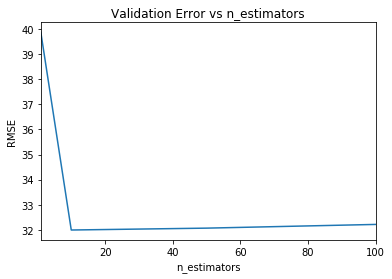

In [16]:
n_estimators = [1, 10, 50, 100]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")

In [17]:
best_rmse_rf_, best_estimator_rf_all = best_rmse_param(series)

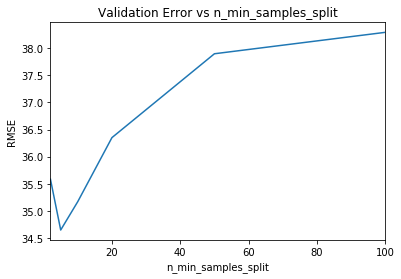

In [19]:
n_min_samples_split = [2,3,4,5,6,7,8,9,10]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = n, n_jobs=8), X_train_all, y_train_all).mean() 
            for n in n_min_samples_split]

series = pd.Series(cv_rf_rmse, index = n_min_samples_split)
plot_rmse_param(series, "n_min_samples_split")

In [20]:
best_rmse_rf, best_split_rf = best_rmse_param(series)

In [21]:
# best_rmse_rf, best_param_rf = best_rmse_param(series)

model_rf = RandomForestRegressor(n_estimators = best_estimator_rf_all, min_samples_split = best_split_rf, n_jobs=8)
score_rf_all, exec_time_all, y_predict_all = train_model(model_rf, X_train_all, y_train_all, X_test_all, y_test_all, 
                                      False)

In [22]:
accuracy_rf_all = get_accuracy(y_predict_all, headway_busBunching_test)
precision_rf_all = get_precision(y_predict_all, headway_busBunching_test)
recall_rf_all = get_recall(y_predict_all, headway_busBunching_test)
fmeasure_rf_all = get_fmeasure(y_predict_all, headway_busBunching_test)

/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [ ]:
# del variables

del df_all_data
del cv_rf_rmse
del series
del model_rf
del y
del X
del X_train_all
del X_test_all
del y_train_all
del y_test_all

In [ ]:
# Support Vector Regressor Model - it takes to long to execute

# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_all, y_train_all).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_all, best_param_svr_all = best_rmse_param(series_svr)

# model_svr_all = SVR(C = best_rmse_svr_all)
# score_svr_all, exec_time_svr_all = train_model(model_svr_all, False)

Usar regressão (reduzir dimensionalidade) -> é linear (RF foi aleatório) ou outros modelos

## Model with less (13) variables

- Todas as variáveis de dia, mês e ano - data do gps é suficiente
- alertInScale - alertIsJamUnifiedAlert é suficiente
- alertLat e alertLon - localização do gps é suficiente
- alertNThumbsUp e alertReliability - alertConfidence é suficiente
- jamDelay e jamLenght - jamSeverity é suficiente

In [23]:
df_selected_data.drop(['DAY(alertDateTime)', 'DAY(jamUpdateDateTime)', 'MONTH(alertDateTime)', 
                       'MONTH(jamUpdateDateTime)', 'YEAR(alertDateTime)', 'YEAR(jamUpdateDateTime)',
                      'alertInScale', 'alertLatitude', 'alertLongitude', 'alertNThumbsUp',
                      'alertReliability', 'jamDelay', 'jamLength'], axis=1, inplace=True)

In [24]:
# changing by shape data
df_selected_data.gpsPointId = np.where(df_selected_data.gpsPointId.isnull(), 0, 
                                       df_selected_data.gpsPointId)
df_selected_data.gpsLat = np.where(df_selected_data.gpsLat.isnull(), df_selected_data.shapeLat,
                                   df_selected_data.gpsLat)
df_selected_data.gpsLon = np.where(df_selected_data.gpsLon.isnull(), df_selected_data.shapeLon, 
                                   df_selected_data.gpsLon)
df_selected_data.distanceToShapePoint = np.where(df_selected_data.distanceToShapePoint.isnull(), 
                                            0, df_selected_data.distanceToShapePoint)


In [25]:
#grouping by weekday and filling NA's with the median of the column
numeric_feats = df_selected_data.dtypes[(df_selected_data.dtypes != "object") & 
                                        (df_selected_data.dtypes != "datetime64[ns]")
                               & (df_selected_data.dtypes != "bool")].index
df_selected_data[numeric_feats] = df_selected_data.groupby(['WEEKDAY(gps_datetime)'])[numeric_feats].transform(lambda x: x.fillna(x.median()))

In [26]:
# Converting bool to float
df_selected_data.alertIsJamUnifiedAlert = df_selected_data.alertIsJamUnifiedAlert.astype(np.float64)
df_selected_data.busBunching = df_selected_data.busBunching.astype(np.float64)

In [27]:
# Converting categorical variable

df_selected_data = pd.get_dummies(df_selected_data)

In [28]:
# y = df_all_data.drop('busBunching', axis=1) # with classifier produce error
y_sel = df_selected_data['headway']
df_selected_data.drop('headway', axis=1, inplace=True)

X_sel = df_selected_data

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.5)

headway_busBunching_test_sel = X_test_sel[['headwayThreshold', 'busBunching']]
X_test_sel.drop('busBunching', axis=1, inplace=True)
X_train_sel.drop('busBunching', axis=1, inplace=True)

/home/veruska/.local/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [48]:
# best_rmse_rf_sel, best_param_rf_sel = best_rmse_param(series)

model_rf_sel = RandomForestRegressor(n_estimators = best_estimator_rf_all,  min_samples_split = best_split_rf_all, n_jobs=8)
score_rf_sel, exec_time_sel, y_predict_sel = train_model(model_rf_sel, X_train_sel, y_train_sel, X_test_sel, y_test_sel, False)

In [49]:
accuracy_rf_sel = get_accuracy(y_predict_sel, headway_busBunching_test_sel)
precision_rf_sel = get_precision(y_predict_sel, headway_busBunching_test_sel)
recall_rf_sel = get_recall(y_predict_sel, headway_busBunching_test_sel)
fmeasure_rf_sel = get_fmeasure(y_predict_sel, headway_busBunching_test_sel)

/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/veruska/.local/lib/python3.6/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [ ]:
# cs = [0.01, 1, 5, 10, 25, 50]
# cv_svr_rmse = [rmse_cv(SVR(C = c), X_train_sel, y_train_sel).mean() 
#             for c in cs]

# series_svr = pd.Series(cv_svr_rmse, index = cs)
# plot_rmse_param(series_svr, "C")

In [ ]:
# best_rmse_svr_sel, best_param_svr_sel = best_rmse_param(series_svr)

# model_svr_sel = SVR(C = best_param_svr_sel)
# score_svr_sel, exec_time_sel_svr = train_model(model_svr_sel, False)

## Results

Execution just with Random Forest because is more efficient with good accuracy.

In [40]:
print("Data: %s rows" % rows_number)
print("Random Forest Model - All Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_all, best_split_rf, accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, exec_time_all))
print("Random Forest Model - Less Variables: \nEstimators = %s \nN_Split = %s \nAccuracy = %s \nPrecision = %s \nRecall = %s \nF-Measure = %s \nR2 = %s \nExecution time = %s \n" % 
      (best_estimator_rf_sel, best_split_rf_sel, accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, exec_time_sel))

# print("SVR Model - All Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr, best_rmse_svr, score_svr, exec_time_svr_all))
# print("SVR Model - Less Variables: \nEstimators = %s \nRMSE = %s \nR2 = %s \nExecution time = %s \n" % 
#       (best_param_svr_sel, best_rmse_svr_sel, score_svr_sel, exec_time_svr_sel))


Data: 1500 rows
Random Forest Model - All Variables: 
Estimators = 10 
N_Split = 5 
RMSE = 34.6542902826426 
Accuracy = 0.8828229027962716 
Precision = 0.6666666666666666 
Recall = 0.06593406593406594 
F-Measure = 0.12 
R2 = 0.5847905723441692 
Execution time = 0.3241603374481201 

Random Forest Model - Less Variables: 
Estimators = 100 
N_Split = 2 
RMSE = 30.302239539104363 
Accuracy = 0.8961384820239681 
Precision = 0.6875 
Recall = 0.13095238095238096 
F-Measure = 0.22 
R2 = 0.625596577148344 
Execution time = 0.45275187492370605 



In [43]:
def plot_results(df_results, name):
    fig, ax = plt.subplots(figsize=(7,5))
    results_plot = df_results.plot.bar(x = "Input", logy=True, grid=True, colormap="tab20b", ax=ax, rot=0)
    plt.xlabel("")
    
    results_plot.get_figure().savefig(path + name)

                     Input  Accuracy  Precision    Recall  F-Measure  \
0       RF - All variables  0.882823   0.666667  0.065934   0.120000   
1  RF - Selected variables  0.894807   0.647059  0.130952   0.217822   

         R2  Execution Time (Min)  
0  0.584791              0.005403  
1  0.612431              0.005314  


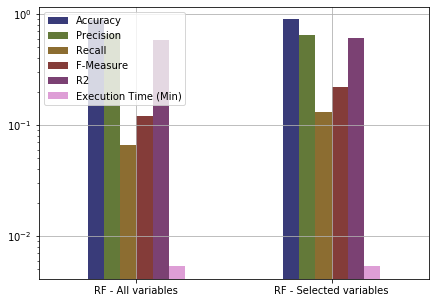

In [52]:
labels = ["Input","Accuracy","Precision","Recall","F-Measure","R2","Execution Time (Min)"]
results = []
results.append(["RF - All variables", accuracy_rf_all, precision_rf_all, recall_rf_all, fmeasure_rf_all, score_rf_all, (exec_time_all/60)])
results.append(["RF - Selected variables", accuracy_rf_sel, precision_rf_sel, recall_rf_sel, fmeasure_rf_sel, score_rf_sel, (exec_time_sel/60)])

df_results = pd.DataFrame.from_records(results, columns=labels)
print(df_results)

plot_results(df_results, "results_comparison_rf.png")

In [53]:
df_results

,Input,Accuracy,Precision,Recall,F-Measure,R2,Execution Time (Min)
0,RF - All variables,0.882823,0.666667,0.065934,0.120000,0.584791,0.005403
1,RF - Selected variables,0.894807,0.647059,0.130952,0.217822,0.612431,0.005314
